In [1]:
!pip install git+https://github.com/githubharald/CTCDecoder.git jiwer python-bidi arabic-reshaper

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/githubharald/CTCDecoder.git to /tmp/pip-req-build-dvjhxrvf
  Running command git clone -q https://github.com/githubharald/CTCDecoder.git /tmp/pip-req-build-dvjhxrvf
  Resolved https://github.com/githubharald/CTCDecoder.git to commit 6b5c3dd34944e5399a7308e241319b7f9c47e7c3


In [2]:
# Memilih GPU yang akan digunakan (contohnya: GPU #7)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [3]:
import importlib
import pegon_utils
importlib.reload(pegon_utils)
from pegon_utils import PEGON_CHARS, CHAR_MAP, OCRDataset

In [4]:
for i in CHAR_MAP.keys():
    try:
        assert len(i) == 1
    except AssertionError:
        print(i)
        raise

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

from PIL import Image

import json
import os
import glob
import re
import datetime
import shutil
import pickle
import unicodedata

from functools import partial

from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import random

import matplotlib.pyplot as plt

seed = 2023
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
model_name = 'ctc-crnn-no-stretch'

In [7]:
os.makedirs(model_name, exist_ok=True)

In [8]:
# Define the OCR model architecture
class CTCCRNNNoStretch(nn.Module):
    def __init__(self, num_classes, image_height, image_width, model_output_len,
                 dropout_rate, conv_channels, lstm_sizes):
        super(self.__class__, self).__init__()

        self.model_output_len = model_output_len
        self.image_height = image_height
        self.image_width = image_width
        self.conv_channels = conv_channels

        # CNN part, downsampling 2 times
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=conv_channels[0],
                               kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=conv_channels[0],
                               out_channels=conv_channels[1],
                               kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # first dense
        self.fc1 = nn.Linear(in_features=conv_channels[1] * (self.image_height//4),
                             out_features=conv_channels[1])
        self.dropout = nn.Dropout(dropout_rate)

        # RNN part
        self.lstm1 = nn.LSTM(input_size=conv_channels[1], hidden_size=lstm_sizes[0],
                             bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=lstm_sizes[0]*2, hidden_size=lstm_sizes[1],
                             bidirectional=True, batch_first=True)

        self.fc2 = nn.Linear(in_features=2*lstm_sizes[1], out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.pool2(x)
        
        x = F.interpolate(x, size=(self.image_height//4, self.model_output_len),
                          mode='bilinear', align_corners=False)
        
        x = x.permute(0, 3, 1, 2).reshape(x.shape[0],
                                          x.shape[3],
                                          x.shape[1] * x.shape[2])
#         print(x.shape)

        x = self.fc1(x)
#         print(x.shape)
        x = self.dropout(x)
    
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc2(x)
        x = x.log_softmax(2)
        return x
        return x

In [9]:
from PIL import ImageOps

class ResizeAndPadHorizontal:
    def __init__(self, target_w, target_h):
        self.target_w = target_w
        self.target_h = target_h

    def __call__(self, img):
        # Calculate scaling factor
        h = img.height
        w = img.width
        scale_factor = self.target_h / h
        
        # Resize image
        new_h = round(h * scale_factor)
        new_w = round(w * scale_factor)        
        
        # Pad image if necessary
        if new_w > self.target_w:
            img = img.resize((self.target_w, new_h))
        elif new_w <= self.target_w:
            img = img.resize((new_w, new_h))
            pad_width = self.target_w - new_w
            img = ImageOps.expand(img, (pad_width, 0, 0, 0), fill=255)

        assert img.height == self.target_h, f'Expected new height ({h}x{scale_factor}={new_h}) to be equal to target {self.target_h} but got {img.size[0]}'
        assert img.width == self.target_w, f'Expected new width to be equal to target {self.target_w} but got {img.size[1]}'
        return img

In [10]:
importlib.reload(pegon_utils)
from pegon_utils import OCRDataset, QuranAnnotatedDataset, model_length
from torch.utils.data import random_split, ConcatDataset

pegon_synth_dataset = OCRDataset().load('/workspace/Dataset/Synthesized-split/metadata.json')

pegon_synth_dataset.char_map = CHAR_MAP


dataset_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ResizeAndPadHorizontal(target_w=model_length(b=2,c=100)(pegon_synth_dataset.max_seq_len),
                           target_h=pegon_synth_dataset.avg_img_h),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

pegon_synth_dataset.transform = dataset_transforms

train_synth_dataset, val_synth_dataset = random_split(pegon_synth_dataset,
                                                      lengths=[round(len(pegon_synth_dataset) * frac) for frac in [0.7, 0.3]])

quran_train_dataset = QuranAnnotatedDataset('/workspace/Dataset/Quran data set/dicriticText/traning',
                      image_transform=dataset_transforms)
quran_test_dataset = QuranAnnotatedDataset('/workspace/Dataset/Quran data set/dicriticText/test',
                      image_transform=dataset_transforms)

train_dataset = ConcatDataset((train_synth_dataset, quran_train_dataset))
val_dataset = ConcatDataset((val_synth_dataset, quran_test_dataset))

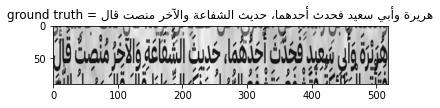

In [11]:
import arabic_reshaper
from bidi.algorithm import get_display

to_arabic_display = lambda text: get_display(arabic_reshaper.reshape(text))
img, label = random.choice(train_dataset)

gt = (''.join([PEGON_CHARS[l] for l in filter(lambda x:x!= 0, label)]))
tensor_to_display = lambda x : transforms.ToPILImage()(transforms.RandomHorizontalFlip(p=1)(x))
plt.imshow(tensor_to_display(img[0]), cmap='gray'); plt.title(f'ground truth = {to_arabic_display(gt)}'); plt.show()

In [12]:
importlib.reload(pegon_utils)
from pegon_utils import model_length

model = CTCCRNNNoStretch(num_classes=len(CHAR_MAP),
                         image_height=pegon_synth_dataset.avg_img_h,
                         image_width=pegon_synth_dataset.avg_img_w,
                         model_output_len=model_length(b=2,c=100)(pegon_synth_dataset.max_seq_len),
                         dropout_rate=0,
                         conv_channels=[16, 16],
                         lstm_sizes=[256, 128])

In [13]:
importlib.reload(pegon_utils)
from pegon_utils import CTCTrainer, FocalCTCLoss

# Train the model
trainer = CTCTrainer(model=model,
                     max_norm=1.0,
#                      lr=1e-3,
                     optimizer=optim.AdamW(model.parameters(), lr=1e-3),
                     batch_size=64,
#                      criterion=FocalCTCLoss(zero_infinity=True,
#                                             alpha=0.25,
#                                             gamma=0.75),
                     dataset=train_dataset)

In [16]:
assert trainer.model(train_dataset[0][0].unsqueeze(0).to(trainer.device)).shape[-1] == len(CHAR_MAP)

In [17]:
timestamp = datetime.datetime.now()
print(timestamp)

2023-05-14 13:14:53.921046


In [18]:
trainer.train(num_epochs=10)

Epoch [1/10] | Batch [942/942] | Running Loss: 3750.5491: 100%|██████████| 942/942 [08:26<00:00,  1.86it/s]
Epoch [2/10] | Batch [942/942] | Running Loss: 2797.2295: 100%|██████████| 942/942 [08:12<00:00,  1.91it/s]
Epoch [3/10] | Batch [942/942] | Running Loss: 1541.1957: 100%|██████████| 942/942 [10:12<00:00,  1.54it/s]
Epoch [4/10] | Batch [942/942] | Running Loss: 1057.6343: 100%|██████████| 942/942 [11:02<00:00,  1.42it/s]
Epoch [5/10] | Batch [942/942] | Running Loss: 827.2294: 100%|██████████| 942/942 [10:28<00:00,  1.50it/s]
Epoch [6/10] | Batch [942/942] | Running Loss: 626.1335: 100%|██████████| 942/942 [10:10<00:00,  1.54it/s]
Epoch [7/10] | Batch [942/942] | Running Loss: 451.1064: 100%|██████████| 942/942 [10:23<00:00,  1.51it/s]
Epoch [8/10] | Batch [942/942] | Running Loss: 396.9142: 100%|██████████| 942/942 [11:29<00:00,  1.37it/s]
Epoch [9/10] | Batch [942/942] | Running Loss: 337.7961: 100%|██████████| 942/942 [12:01<00:00,  1.31it/s]
Epoch [10/10] | Batch [942/942] |

Finished training!


CTCCRNNNoStretch(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=352, out_features=16, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (lstm1): LSTM(16, 256, batch_first=True, bidirectional=True)
  (lstm2): LSTM(512, 128, batch_first=True, bidirectional=True)
  (fc2): Linear(in_features=256, out_features=80, bias=True)
)

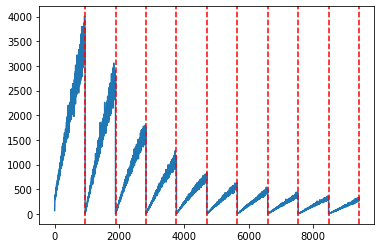

In [19]:
trainer.plot_history(path=f'{model_name}/{timestamp}.train.png')
trainer.save(f'{model_name}/{timestamp}.pt')

In [20]:
importlib.reload(pegon_utils)
from pegon_utils import CTCDecoder, BestPathDecoder, evaluate, plot_cer_wer

In [21]:
# dataloader = trainer.dataloader
dataloader = DataLoader(val_dataset,
                        batch_size=trainer.batch_size,
                        shuffle=True,
                        collate_fn=trainer.collate_fn)

In [22]:
# timestamp = '2023-05-02 15:56:58.754379'
# timestamp = '2023-05-02 20:53:48.971202'
model_path = f'{model_name}/{timestamp}.pt'

In [23]:
decoder = BestPathDecoder.from_path(model_path, CHAR_MAP, blank_char=PEGON_CHARS[0])
cers, wers = evaluate(decoder, dataloader)

 Example: 25327 | CER: 0.0952 | WER: 0.4041: 100%|██████████| 396/396 [03:18<00:00,  1.99it/s]


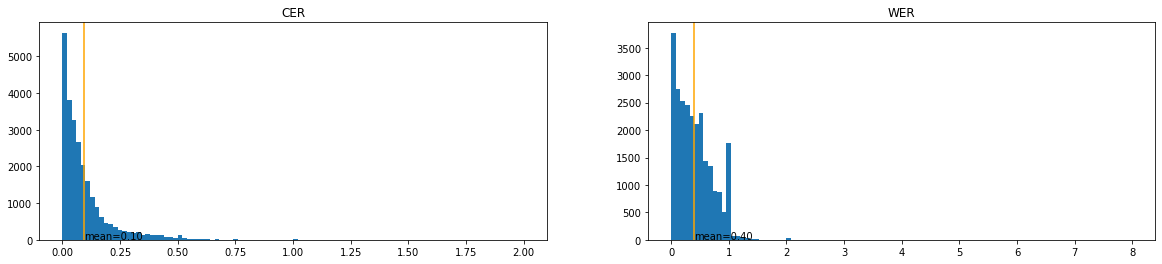

In [24]:
plot_cer_wer(cers, wers, path=f'{model_name}/{timestamp}.wer-cer.png')

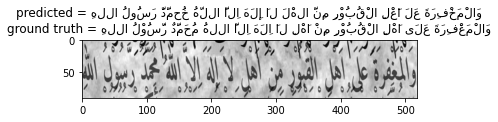

In [25]:
# demo

import arabic_reshaper
from bidi.algorithm import get_display

to_arabic_display = lambda text: get_display(text)
img, label = random.choice(val_dataset)
img, _, _ = dataloader.collate_fn([[img, label]])

gt = (''.join([PEGON_CHARS[l] for l in filter(lambda x:x!= 0, label)]))

predicted = decoder.infer(img.cuda())[0]

tensor_to_display = lambda x : transforms.ToPILImage()(transforms.RandomHorizontalFlip(p=1)(x))

plt.imshow(tensor_to_display(img[0]), cmap='gray'); plt.title(f'predicted = {to_arabic_display(predicted)}\nground truth = {to_arabic_display(gt)}'); plt.show()

In [26]:
import importlib
import pegon_utils
importlib.reload(pegon_utils)
from pegon_utils import FilenameOCRDataset, PegonAnnotatedDataset, ctc_collate_fn
import pdb

annotated_dataset = PegonAnnotatedDataset('/workspace/Dataset/pegon-ocr-patched',
                                          image_transform=dataset_transforms)

annotated_dataloader = DataLoader(annotated_dataset, shuffle=True,
                                  batch_size=trainer.batch_size,
                                  collate_fn=ctc_collate_fn)
cers, wers = evaluate(decoder, annotated_dataloader)

 Example: 1976 | CER: 0.6729 | WER: 1.3325: 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


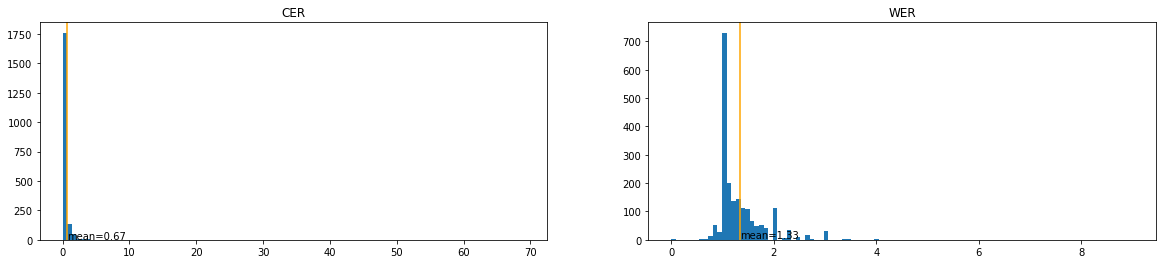

In [27]:
plot_cer_wer(cers, wers, path=f'{model_name}/{timestamp}.eval.wer-cer.png')

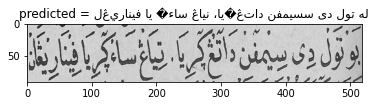

In [28]:
# demo

import arabic_reshaper
from bidi.algorithm import get_display

to_arabic_display = lambda text: get_display(arabic_reshaper.reshape(text))
img, label, _ = dataloader.collate_fn([random.choice(annotated_dataset)])

predicted = decoder.infer(img.cuda())[0]

tensor_to_display = lambda x : transforms.ToPILImage()(transforms.RandomHorizontalFlip(p=1)(x))

plt.imshow(tensor_to_display(img[0]),cmap='gray'); plt.title(f'predicted = {to_arabic_display(predicted)}'); plt.show()